# Andrew Nell
# HW6
# fbb skeleton notebook for PUI2017 HW6

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as smf

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

np.random.seed(100)

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [208]:
##############################################################################
# Download Pluto Data and Move to PUIData
os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-"
          "maps/open-data/mn_mappluto_16v2.zip")
os.system("mv mn_mappluto_16v2.zip "  + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/mn_mappluto_16v2.zip -d " + 
          os.getenv("PUIDATA")+"/Manhattan") 

256

In [282]:
##############################################################################
# Download data from API and move to PUIdata

# API only downloaded 1000 lines of data, had to use the other download method
# I assume that a token/key is needed to download more data

#!wget -O - "https://data.cityofnewyork.us/resource/m46j-75iy.csv" > "nrg.csv"
#os.system("mv nrg.csv " + os.getenv("PUIDATA"))

--2017-10-23 21:30:44--  https://data.cityofnewyork.us/resource/m46j-75iy.csv
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: “STDOUT”

    [ <=>                                   ] 331,619     --.-K/s   in 0.03s   

2017-10-23 21:30:45 (10.4 MB/s) - written to stdout [331619]



0

In [296]:
##############################################################################
# Download data from internet and move to PUIdata
!wget "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv"
os.system("mv rows.csv "  + os.getenv("PUIDATA"))

--2017-10-23 22:02:31--  https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
Resolving data.cityofnewyork.us... 52.206.140.199
Connecting to data.cityofnewyork.us|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4433512 (4.2M) [text/csv]
Saving to: “rows.csv”

100%[======================================>] 4,433,512   7.90M/s   in 0.5s    

Last-modified header invalid -- time-stamp ignored.
2017-10-23 22:02:31 (7.90 MB/s) - “rows.csv” saved [4433512/4433512]



0

In [2]:
##############################################################################
# Read Energy and Water data straight from API
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/rows.csv")

# read Pluto Data from PUIdata
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                  "/Manhattan/MNMapPLUTO.shp")

In [3]:
# Check to see if data pull ALL data correctly
len(nrg)

16170

In [4]:
# Reset index to remove water benchmarking column
nrg = nrg.reset_index()
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
nrg.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [6]:
##############################################################################
# Rename certain variables to no space names
nrg = nrg.rename(columns={'Site EUI(kBtu/ft2)': 'site_eui_kbtu_ft2', 
                          'Reported Property Floor Area (Building(s)) (ft²)': 
                          'reported_property_floor_area_building_s_ft'})

In [7]:
bsize.columns

Index([   u'Borough',      u'Block',        u'Lot',         u'CD',
           u'CT2010',     u'CB2010', u'SchoolDist',    u'Council',
          u'ZipCode',   u'FireComp', u'PolicePrct', u'HealthArea',
        u'SanitBoro', u'SanitDistr',   u'SanitSub',    u'Address',
        u'ZoneDist1',  u'ZoneDist2',  u'ZoneDist3',  u'ZoneDist4',
         u'Overlay1',   u'Overlay2',    u'SPDist1',    u'SPDist2',
          u'SPDist3',  u'LtdHeight',  u'SplitZone',  u'BldgClass',
          u'LandUse',  u'Easements',  u'OwnerType',  u'OwnerName',
          u'LotArea',   u'BldgArea',    u'ComArea',    u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea',  u'StrgeArea',
       u'FactryArea',  u'OtherArea', u'AreaSource',   u'NumBldgs',
        u'NumFloors',   u'UnitsRes', u'UnitsTotal',   u'LotFront',
         u'LotDepth',  u'BldgFront',  u'BldgDepth',        u'Ext',
         u'ProxCode', u'IrrLotCode',    u'LotType',   u'BsmtCode',
       u'AssessLand',  u'AssessTot', u'ExemptLand',  u'ExemptT

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

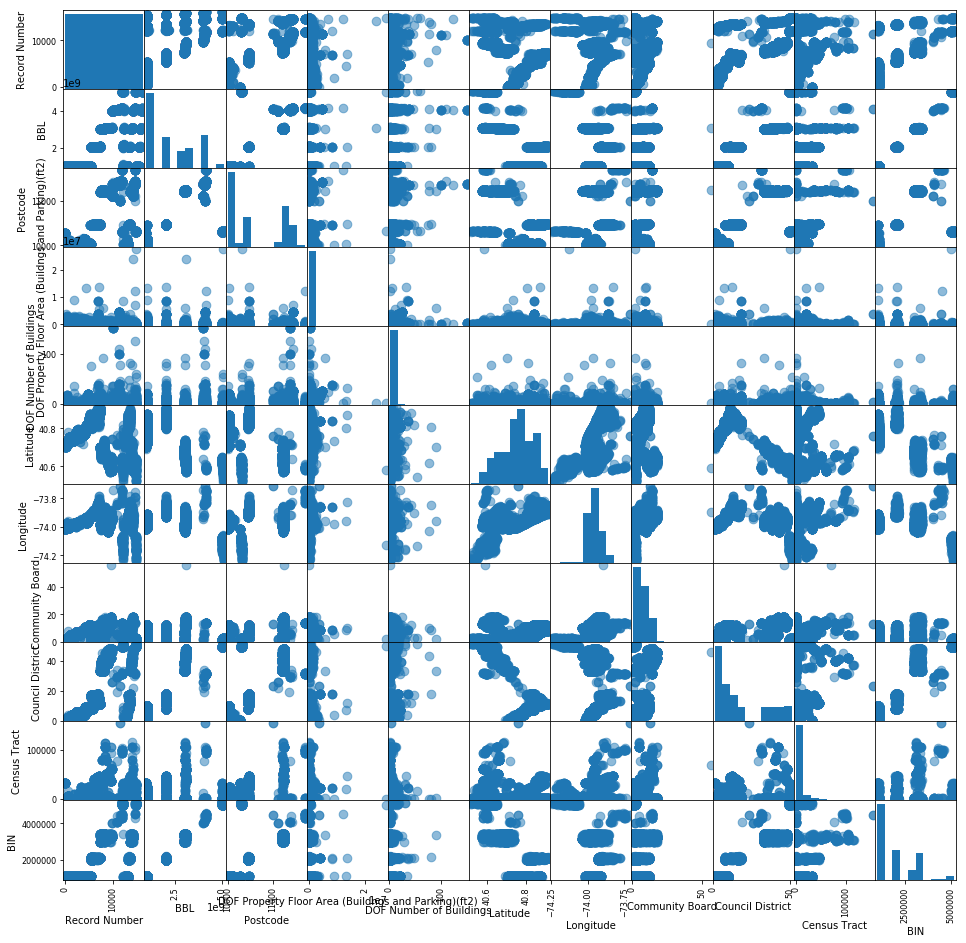

In [ ]:
#Create a scatter matrix to see the data and determine any easy relationships

scatter_matrix (nrg, s=300, figsize=(16, 16));



#### Figure 1: scatter matrix of all numerical values in the Energy and Water use files. 
It is important to note that there is no energy usage and square footage data plotted here, which means that the data could not be plotted numerically. This will need to be fixed to draw any conclusions out of the data. 

The categorical data sets tend to form straight lines as they fit into numerical catgeories (Zip Code, BBL etc.). Only the non-categorical data sets like Floor Area show varied plots. 

Interestingly the latitude and longitude plot looks like the shape of New York. 

In [8]:
# Print data types to see what needs to be converted
nrg.dtypes

Record Number                                                        int64
BBL                                                                float64
Co-reported BBL Status                                              object
BBLs Co-reported                                                    object
Reported NYC Building Identificaiton Numbers (BINs)                 object
Street Number                                                       object
Street Name                                                         object
Borough                                                             object
Postcode                                                           float64
DOF Benchmarking Submission Status                                  object
site_eui_kbtu_ft2                                                   object
Weather Normalized Site EUI(kBtu/ft2)                               object
Source EUI(kBtu/ft2)                                                object
Weather Normalized Source

In [9]:
##############################################################################
# Convert data types to Numeric Values
nrg["site_eui_kbtu_ft2"] = pd.to_numeric(nrg["site_eui_kbtu_ft2"], 
                                         errors='coerce')
nrg['reported_property_floor_area_building_s_ft'] = \
(pd.to_numeric(nrg['reported_property_floor_area_building_s_ft'], 
               errors='coerce'))


In [10]:
# Check Data Types
print(nrg['site_eui_kbtu_ft2'].dtypes)
print(nrg['reported_property_floor_area_building_s_ft'].dtypes)

float64
float64


In [11]:
#How many missing values?
indx = np.isnan(nrg['site_eui_kbtu_ft2']).sum()
print ("invalid entries for Site EUI changed to NaN %d"%sum(indx))
indx = np.isnan(nrg['reported_property_floor_area_building_s_ft']).sum()
print ("invalid entries for Property Floor Area changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries for Site EUI changed to NaN 4623
invalid entries for Property Floor Area changed to NaN 3125


In [12]:
##############################################################################
nrg = nrg[['BBL','reported_property_floor_area_building_s_ft','site_eui_kbtu_ft2']]
nrg.head()

,BBL,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2
0,1.000410e+09,918919.0,NaN
1,4.021460e+09,NaN,NaN
2,2.027620e+09,64200.0,NaN
3,1.006700e+09,NaN,NaN
4,2.048300e+09,50000.0,NaN


In [13]:
# Drop all irrelavnt collumns
bsize = bsize.drop(['Borough','Block','Lot','CD','CT2010','CB2010',
                    'SchoolDist','Council','ZipCode','FireComp',
                    'PolicePrct','HealthArea','SanitBoro',
                    'SanitDistr','SanitSub','Address','ZoneDist1',
                    'ZoneDist2','ZoneDist3','ZoneDist4','Overlay1',
                    'Overlay2','SPDist1','SPDist2','SPDist3',
                    'LtdHeight','SplitZone','BldgClass','LandUse',
                    'Easements','OwnerType','OwnerName','LotArea',
                    'BldgArea','ComArea','ResArea','OfficeArea',
                    'RetailArea','GarageArea','StrgeArea',
                    'FactryArea','OtherArea','AreaSource','NumBldgs',
                    'NumFloors','LotFront','LotDepth','BldgFront',
                    'BldgDepth','Ext','ProxCode','IrrLotCode',
                    'LotType','BsmtCode','AssessLand','AssessTot',
                    'ExemptLand','ExemptTot','YearAlter1',
                    'YearAlter2','HistDist','Landmark','BuiltFAR',
                    'ResidFAR','CommFAR','FacilFAR','BoroCode',
                    'CondoNo','Tract2010','XCoord','YCoord',
                    'ZoneMap','ZMCode','Sanborn','TaxMap',
                    'EDesigNum','APPBBL','APPDate',
                    'PLUTOMapID','Version','MAPPLUTO_F','SHAPE_Leng', 
                    'SHAPE_Area', 'geometry'], axis=1)


In [14]:
# Check Data
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1987,1.000090e+09
2,500,602,1902,1.000158e+09
3,0,50,1900,1.000130e+09
4,0,0,1900,1.000010e+09


In [15]:
# Check Data
bsize.dtypes

UnitsRes        int64
UnitsTotal      int64
YearBuilt       int64
BBL           float64
dtype: object

In [16]:
# Convert data types to float
bsize.UnitsTotal = bsize.UnitsTotal.astype(float)
bsize.UnitsRes = bsize.UnitsRes.astype(float)
bsize.YearBuilt = bsize.YearBuilt.astype(float)

In [17]:
#How many missing values?
indx = np.isnan(bsize['UnitsRes']).sum()
print ("invalid entries UnitsRes changed to NaN %d"%sum(indx))
indx = np.isnan(bsize['UnitsTotal']).sum()
print ("invalid entries UnitsTotal changed to NaN %d"%sum(indx))
indx = np.isnan(bsize['BBL']).sum()
print ("invalid entries BBL changed to NaN %d"%sum(indx))


invalid entries UnitsRes changed to NaN 0
invalid entries UnitsTotal changed to NaN 0
invalid entries BBL changed to NaN 0


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [18]:
##############################################################################
# Merge Data sets
Mergedf = nrg.merge(bsize, left_on="BBL", 
                    right_on="BBL").dropna()

In [19]:
# Check Data
Mergedf.head()
#Mergedf.shape

,BBL,reported_property_floor_area_building_s_ft,site_eui_kbtu_ft2,UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,330000.0,125.4,0.0,56.0,1977.0
10,1.010140e+09,841709.0,154.9,0.0,2.0,1999.0
15,1.007660e+09,59468.0,122.3,0.0,8.0,1912.0
16,1.008150e+09,364000.0,117.0,0.0,24.0,1954.0
18,1.005050e+09,235370.0,82.1,0.0,24.0,1926.0


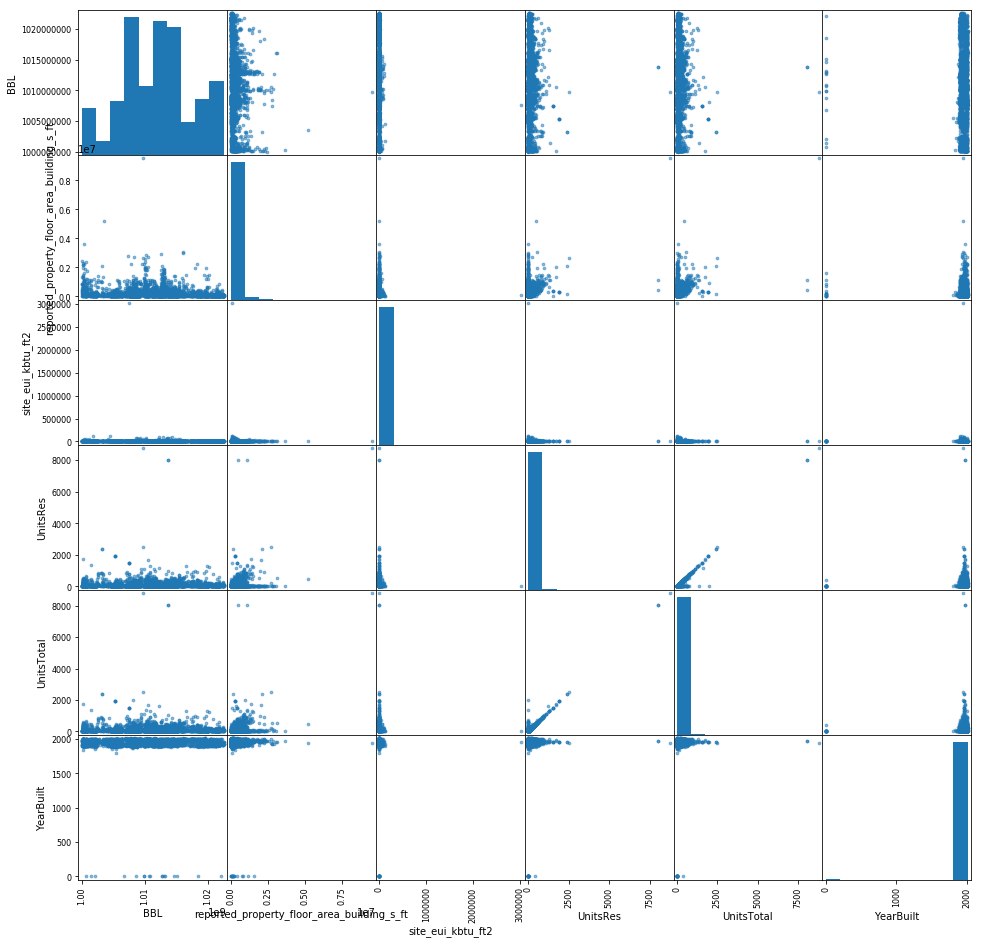

In [20]:
# Plot Scatter matrix of simplified merged dataframe
scatter_matrix (Mergedf, s=30, figsize=(16, 16));

#### Figure 2: Scatter Matrix of cleaned and merged data
From the energy consumption and units (residential and total) and energy consumption and floor area it is diffcult to dtermine anything as the info has several outliers which make visualising difficult in this format. 

There appears to be some direct relationship between the units (residential and total) and floor area. 

BBLs and Year Built provide no insights. 

In [21]:
##############################################################################
# Add Column for Total Energy Consumption independent of Area
Mergedf["EnergyConsumed"] = (Mergedf.site_eui_kbtu_ft2 * 
                             Mergedf.reported_property_floor_area_building_s_ft)

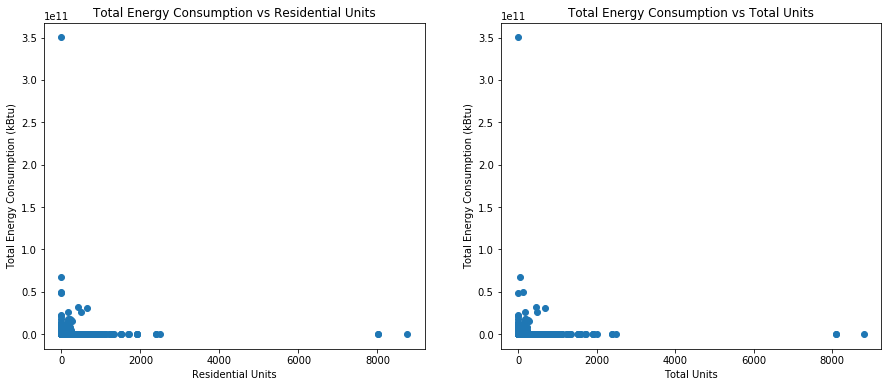

In [22]:
# Set up Plots
pl.figure(figsize=(15,6))

# Plot First Figure
pl.subplot(121)
pl.plot(Mergedf.UnitsRes,Mergedf.EnergyConsumed,"o")

# Format First Figure
pl.title("Total Energy Consumption vs Residential Units")
pl.xlabel("Residential Units")
pl.ylabel("Total Energy Consumption (kBtu)")

# Plot Second Figure
pl.subplot(122)
pl.plot(Mergedf.UnitsTotal,Mergedf.EnergyConsumed,"o")

# Format Second Figure
pl.title("Total Energy Consumption vs Total Units")
pl.xlabel("Total Units")
pl.ylabel("Total Energy Consumption (kBtu)")

#### Figure 3: Plots of Total Energy Consumption against Number of Residential and Total Units per building
Note how the data has several outliers that skew any possibility of gaining insights from the figures. We need to change the size of the x and y limits. 

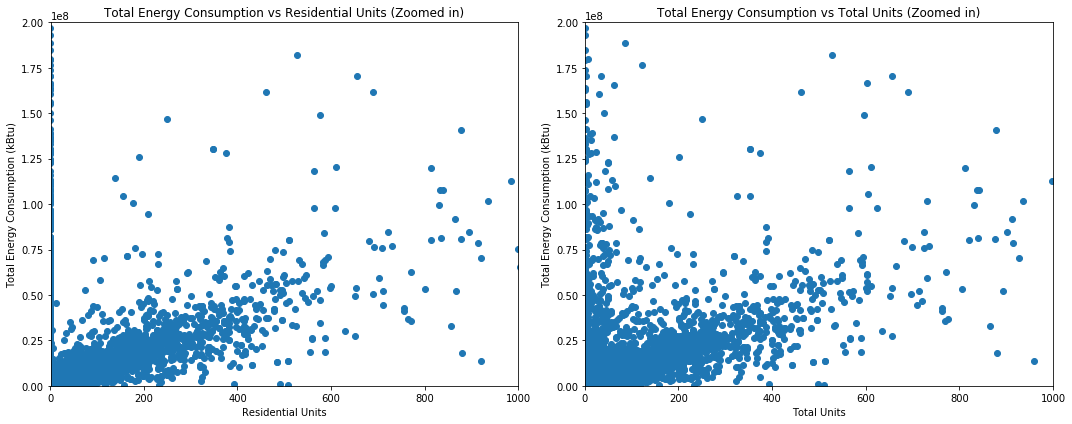

In [23]:
##############################################################################
# Set up Plots
pl.figure(figsize=(15,6))

# Plot First Figure
pl.subplot(121)
pl.plot(Mergedf.UnitsRes,Mergedf.EnergyConsumed,"o")

# Format First Figure
pl.title("Total Energy Consumption vs Residential Units (Zoomed in)")
pl.xlabel("Residential Units")
pl.ylabel("Total Energy Consumption (kBtu)")
pl.xlim(1,1000)
pl.ylim(1000,2e8)

# Plot Second Figure
pl.subplot(122)
pl.plot(Mergedf.UnitsTotal,Mergedf.EnergyConsumed,"o")

# Format Second Figure
pl.title("Total Energy Consumption vs Total Units (Zoomed in)")
pl.xlabel("Total Units")
pl.ylabel("Total Energy Consumption (kBtu)")
pl.xlim(1,1000)
pl.ylim(1000,2e8);

pl.tight_layout()

#### Figure 4: Zoomed in Plots of Total Energy Consumption against Number of Residential and Total Units per building
Note how there appears rto be some sort of relationship between Energy Consumption and Number of units, the relationship appears direct, however does not seem linear.

I will choose to work with the Residential Units figure because it seems to have a clearer relationship with less outliers. The Total Units has high energy use at low number of units. 

In [24]:
##############################################################################
# Filter data sets to exclude outliers 
Mergedfcut = Mergedf[(Mergedf["EnergyConsumed"] > 1000) & 
                     (Mergedf["UnitsRes"] > 0) & (Mergedf["UnitsRes"] < 1000)]

Data is filtered to exclude irrelevant or skew data:
* Energy Consumed removes data points below 1000 kBtu as these buildings may be unoccupied or not recording data
* Number of Residential units at 0, which means it may be was not captured or iuis not a residential builing
* Number of Residential units over 1000, these data points are the exception and would skew data massively. 

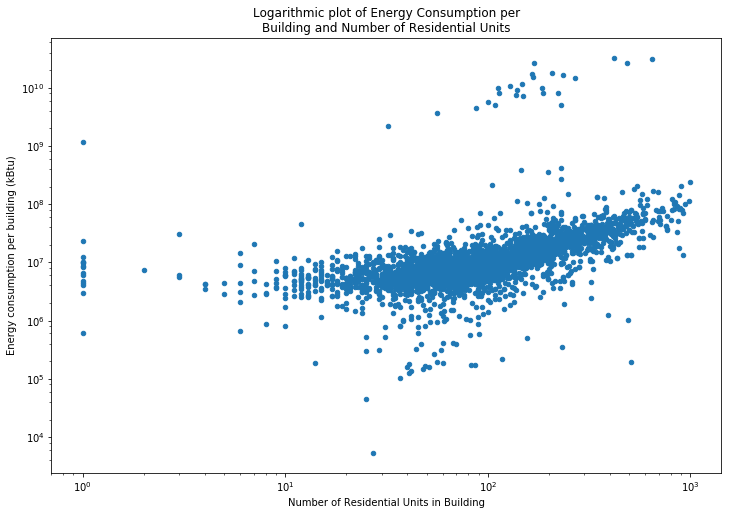

In [25]:
# Plot Scatter of Logs
ax = Mergedfcut.plot(kind='scatter', y='EnergyConsumed', 
                     x='UnitsRes', marker='o', 
                     loglog=True,figsize=(12, 8))

# Format Chart
ax.set_xlabel("Number of Residential Units in Building")
ax.set_ylabel("Energy consumption per building (kBtu)")
ax.set_title("Logarithmic plot of Energy Consumption per\n"
             "Building and Number of Residential Units")

#### Figure 5: Logarithmic plot of Energy Consumption per building vs Number of rediential units
Note there appears to be a much more distinct relationship between the consumption and number of residential units with some outliers still that should be removed, but we will not.

In [26]:
# Create Logarithmic data sets in dataframe
Mergedfcut["EnergyLog"]=np.log(Mergedfcut["EnergyConsumed"])
Mergedfcut["UnitsResLog"]=np.log(Mergedfcut["UnitsRes"])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [27]:
energylm = smf.ols("EnergyLog ~ UnitsResLog",data=Mergedfcut).fit() 

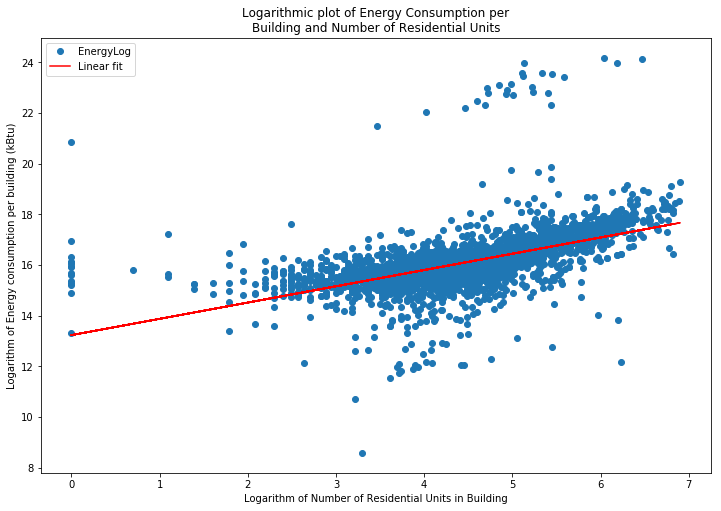

In [28]:
##############################################################################
# Set up Plots
pl.figure(figsize=(12,8))

# Plot Figure
pl.plot(Mergedfcut["UnitsResLog"],Mergedfcut["EnergyLog"],"o")

pl.plot(Mergedfcut["UnitsResLog"],energylm.predict(),"-r",
        label="Linear fit")


# Format Chart
pl.xlabel("Logarithm of Number of Residential Units in Building")
pl.ylabel("Logarithm of Energy consumption per building (kBtu)")
pl.title("Logarithmic plot of Energy Consumption per\n"
             "Building and Number of Residential Units")
pl.legend()

#### Figure 6: Linear fit over Logarithms of energy consumptions per building and Number of residential units
Note there is a cler linear relationship between the logarithmic values of the two variables.

## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 




1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



### 1) and 2)

In [29]:
# Create alternate linear model
energylm2 = smf.ols("UnitsResLog ~ EnergyLog",
                    data=Mergedfcut).fit() 

In [30]:
energylm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              EnergyLog   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     1519.
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          5.02e-276
Time:                        23:53:55   Log-Likelihood:                -4533.5
No. Observations:                3483   AIC:                             9071.
Df Residuals:                    3481   BIC:                             9083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      13.2377      0.075    176.681      0.000        13.091    13.385
UnitsResLog     0.6422      0.016     38.972      0.000         0.610     0.675
==============================================================================
Omnibus:                     2225.266   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91853.800
Skew:                           2.447   Prob(JB):                         0.00
Kurtosis:                      27.677   Cond. No.                         23.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
energylm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            UnitsResLog   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     1519.
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          5.02e-276
Time:                        23:53:55   Log-Likelihood:                -4000.9
No. Observations:                3483   AIC:                             8006.
Df Residuals:                    3481   BIC:                             8018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.1607      0.196    -16.142      0.000        -3.545    -2.777
EnergyLog      0.4730      0.012     38.972      0.000         0.449     0.497
==============================================================================
Omnibus:                     1180.674   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7804.821
Skew:                          -1.450   Prob(JB):                         0.00
Kurtosis:                       9.736   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 The two models have the exact same R-Squared Value. 

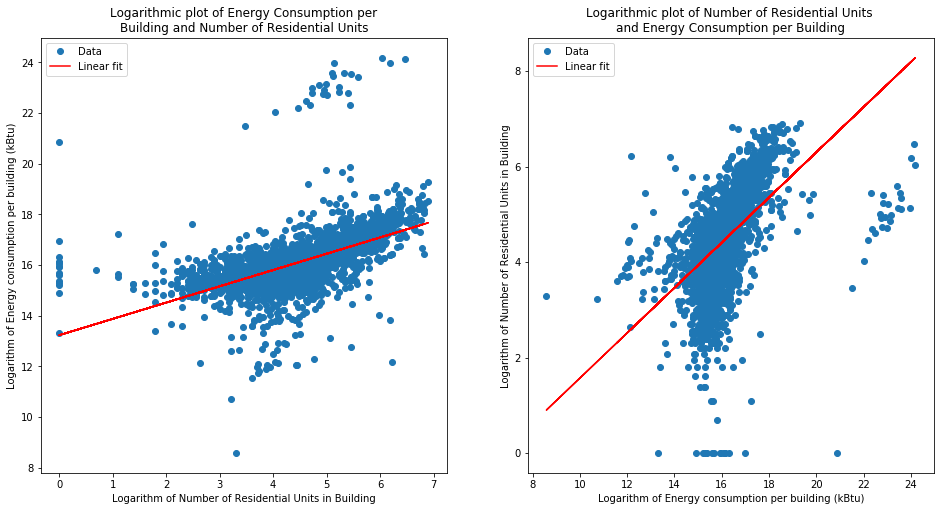

In [338]:
##############################################################################
# Set up Plots
pl.figure(figsize=(16,8))

# Plot Figure 1
pl.subplot(121)
pl.plot(Mergedfcut["UnitsResLog"],Mergedfcut["EnergyLog"],"o", 
        label="Data")
pl.plot(Mergedfcut["UnitsResLog"],energylm.predict(),"-r",
        label="Linear fit")


# Format Chart
pl.xlabel("Logarithm of Number of Residential Units in Building")
pl.ylabel("Logarithm of Energy consumption per building (kBtu)")
pl.title("Logarithmic plot of Energy Consumption per\n"
             "Building and Number of Residential Units")
pl.legend()

# Plot Figure 2
pl.subplot(122)
pl.plot(Mergedfcut["EnergyLog"], Mergedfcut["UnitsResLog"],"o", 
        label="Data")
pl.plot(Mergedfcut["EnergyLog"],energylm2.predict(),"-r",
        label="Linear fit")


# Format Chart
pl.ylabel("Logarithm of Number of Residential Units in Building")
pl.xlabel("Logarithm of Energy consumption per building (kBtu)")
pl.title("Logarithmic plot of Number of Residential Units \n"
         "and Energy Consumption per Building")
pl.legend()

#### Figure 7: Plots of the logarithmic energy consumptions and the logarithmic number of residential units per bulding with the variables swapped across the axes and linear models fitted
Note how the linear model that fits over the graph where the Number of Units is the dependant variable does not fit as well as the model where the Energy consumption was the dependant variable. 

### 3) and 4)

In [339]:
##############################################################################
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and 
(optional) error)''')
    return -1

In [340]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((Mergedfcut['reported_property_floor_area_building_s_ft'])**2 +\
                    (Mergedfcut['site_eui_kbtu_ft2']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(Mergedfcut.UnitsRes)

#These errors need to be propagated properly through the log

In [341]:
errorsInLogNrg = np.abs(errorsnrg / Mergedfcut.EnergyConsumed / np.log(10))
errorsInLogUnits = np.abs(errorsunits / Mergedfcut.UnitsRes / np.log(10))

Mergedfcut['errorsnrg'] = errorsInLogNrg
Mergedfcut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [348]:
##############################################################################
chinrg = chi2(Mergedfcut["EnergyLog"],energylm.predict(),
              Mergedfcut.errorsnrg)
chinrg

16604490442734.094

In [349]:
##############################################################################
chiunit = chi2(Mergedfcut["UnitsResLog"],energylm2.predict(),
               Mergedfcut.errorsunits)
chiunit

1540723.721887101

Therefore the chi squared test is suggesting that the Units vs Energy Model is better than the Energy vs Units model. However both models are not good predictors of the actual values and are way off the chi squared figure scale. 

propagation of errors on the log:https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

### 5)

In [350]:
##############################################################################
Mergedfcut['EnergyLog2'] = Mergedfcut['EnergyLog'] * Mergedfcut['EnergyLog']
Mergedfcut['UnitsResLog2'] = Mergedfcut['UnitsResLog'] * Mergedfcut['UnitsResLog'] 

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [355]:
##############################################################################
nrg_q_lm = smf.ols("EnergyLog ~ UnitsResLog + UnitsResLog2",
                   data=Mergedfcut).fit() 
units_q_lm = smf.ols("UnitsResLog ~ EnergyLog + EnergyLog2",
                     data=Mergedfcut).fit() 

# ort plots for linear model
arr = pd.DataFrame({"Pred":nrg_q_lm.predict(),"ex":Mergedfcut["UnitsResLog"]})
arr = arr.sort("ex",ascending=True)

arr2 = pd.DataFrame({"Pred":units_q_lm.predict(),"ex":Mergedfcut["EnergyLog"]})
arr2 = arr2.sort("ex",ascending=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


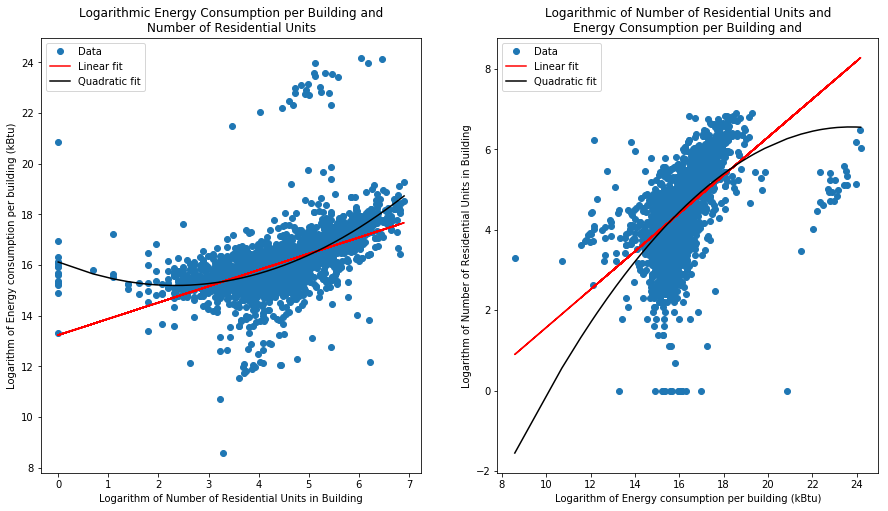

In [357]:
##############################################################################
# Set up Plots
pl.figure(figsize=(15,8))

# Plot Figure 1
pl.subplot(121)
pl.plot(Mergedfcut["UnitsResLog"],Mergedfcut["EnergyLog"],"o", 
        label="Data")
pl.plot(Mergedfcut["UnitsResLog"],energylm.predict(),"-r",
        label="Linear fit")
pl.plot(arr["ex"],arr["Pred"],"-k",
        label="Quadratic fit")

# Format Chart
pl.xlabel("Logarithm of Number of Residential Units in Building")
pl.ylabel("Logarithm of Energy consumption per building (kBtu)")
pl.title("Logarithmic Energy Consumption per Building and\n"  
         "Number of Residential Units")
pl.legend()

# Plot Figure 2
pl.subplot(122)
pl.plot(Mergedfcut["EnergyLog"],Mergedfcut["UnitsResLog"],"o", 
        label="Data")
pl.plot(Mergedfcut["EnergyLog"],energylm2.predict(),"-r",
        label="Linear fit")
pl.plot(arr2["ex"],arr2["Pred"],"-k",
        label="Quadratic fit")

# Format Chart
pl.ylabel("Logarithm of Number of Residential Units in Building")
pl.xlabel("Logarithm of Energy consumption per building (kBtu)")
pl.title("Logarithmic of Number of Residential Units and\n"
         "Energy Consumption per Building and")
pl.legend()

#### Figure 8:  Logarithmic plot of Number of residential Units per Building Vs Energy Consumption
Note how Comment here

### 6)

In [370]:
print ("LR : ", -2 * (-energylm.llf - (-nrg_q_lm.llf)))
print ("LR from statsmodels:", nrg_q_lm.compare_lm_test(energylm))

LR :  -368.923988138
LR from statsmodels: (350.05748803440957, 4.1173783312459404e-78, 1.0)


In [372]:
print ("LR : ", -2 * (-energylm2.llf - (-units_q_lm.llf)))
print ("LR from statsmodels:", units_q_lm.compare_lm_test(energylm2))

LR :  -127.988111368
LR from statsmodels: (125.66509403141428, 3.6401100070090345e-29, 1.0)


Therefore .....

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

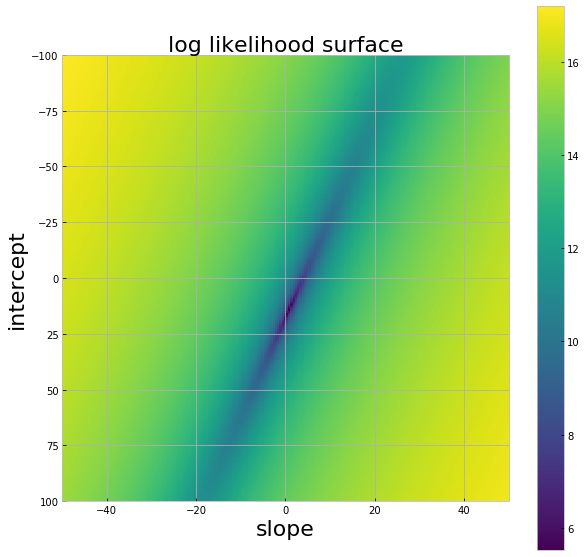

In [42]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Text(0.5,0,'total energy consumption (kBtu)')

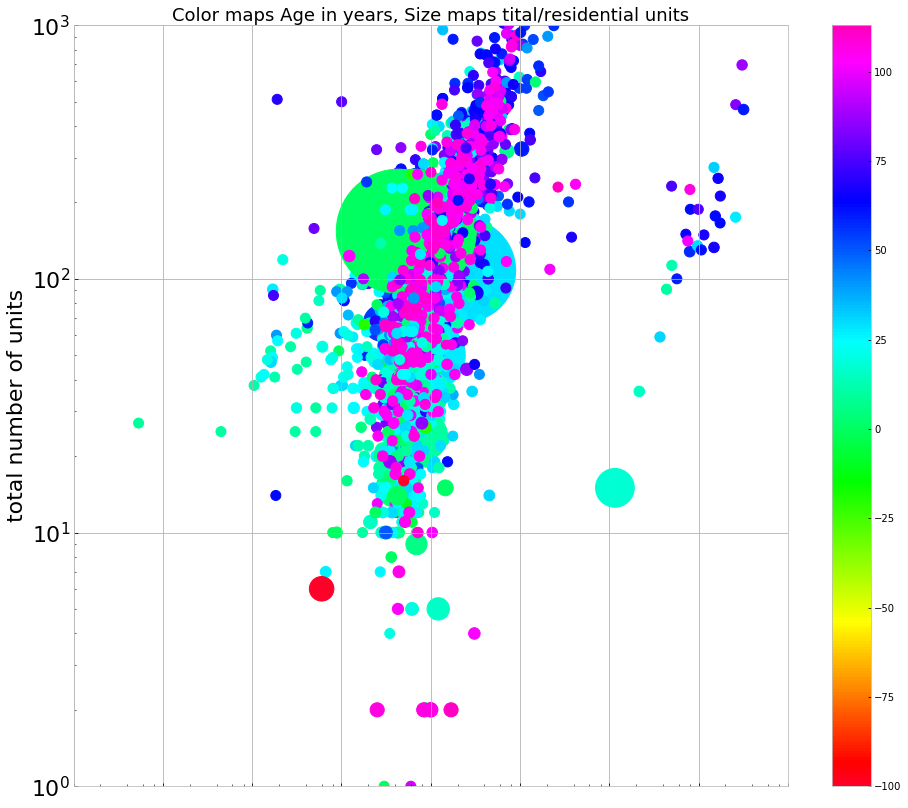

In [49]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)